In [1]:
import sys
sys.path
sys.path.append(r'C:\Users\Filipe\Documents\GitHub\sbibm-ddm-task\sbibm')
sys.path

['c:\\Users\\Filipe\\Documents\\GitHub\\mnle-for-ddms\\notebooks',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\python311.zip',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\DLLs',
 '',
 'C:\\Users\\Filipe\\AppData\\Roaming\\Python\\Python311\\site-packages',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib\\site-packages',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib\\site-packages\\win32',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib\\site-packages\\Pythonwin',
 'C:\\Users\\Filipe\\Documents\\GitHub\\sbibm-ddm-task\\sbibm']

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import time
import torch

from pathlib import Path
from scipy.stats import binom_test
from torch.distributions.transforms import AffineTransform, identity_transform

import sys

sys.path.append(r'C:\Users\Filipe\Documents\GitHub\sbibm-ddm-task')
#sys.path.append(r'C:\Users\Filipe\Documents\GitHub\ssm_simulators')
#sys.path.append(r'C:\Users\Filipe\Documents\GitHub\LANfactory')
#import sbibm

from base_utils import (
    #load_lan,
    #lan_likelihood_on_batch,
    apply_lower_bound_given_mask,
    huber_loss,
    mean_squared_error,
    decode_1d_to_2d_x,
    plot_bar,
)

In [3]:
# Plotting settings
plt.style.use("plotting_settings.mplstyle")
# Colorblind color palette
colors = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
    "#FF0000",
    "#800000",
]

# Fix seed for figures.
seed = 223174  # torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

BASE_DIR = Path.cwd().parent.as_posix()
data_folder = BASE_DIR + "/data/"
model_folder = BASE_DIR + "/models/active/neural_nets/"
save_folder = BASE_DIR + "/data/results/"

model_folder = r"E:\\Filipe_File_Dump\\nns_dump\\nn_comparison\\"

# Set log-likelihood lower bound for all methods, use 1e-7 as the highest bound used during training (e.g., for 10^11 budget LANs).
l_lower_bound = 1e-7
LL_LOWER_BOUND = np.log(l_lower_bound)

seed 223174


## Load DDM task from `sbibm`

In [4]:
# if r'C:\Users\Filipe\Documents\GitHub\mnle_project_repo_online_flowcat' not in sys.path:
#     sys.path.insert(0, r'C:\Users\Filipe\Documents\GitHub\mnle_project_repo_online_flowcat')
#     sys.path.insert(0, r'C:\Users\Filipe\Documents\GitHub\mnle_project_repo_online_flowcat\sbi')
#     sys.path.insert(0, r'C:\Users\Filipe\Documents\GitHub\mnle_project_repo_online_flowcat\sbi\neural_nets\mnle.py')

In [5]:
#task = sbibm.get_task("ddm")
#sys.path.append(r'C:\Users\Filipe\Documents\GitHub\sbibm-ddm-task')

from sbibm.tasks.ddm.task import *
task = sbibm.tasks.ddm.task.DDM(dim_parameters=2)
#task = task.DDM(dim_parameters=2)
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed)  # Passing the seed to Julia.

# Load pre-simulated test data
with open(data_folder + "ddm_training_and_test_data_10mio.p", "rb") as fh:
    theta, x_1d, xos_1d, thos = pickle.load(fh).values()

xos = decode_1d_to_2d_x(xos_1d)

In [11]:
np.shape(thos[0])

torch.Size([10000, 4])

In [12]:
#thos = [prior((10**4,)) for i in range(100)]
thos = [prior((10**4,)) for i in range(1000)]

In [13]:
xos_1d = simulator(prior((10**4,)))
xos = decode_1d_to_2d_x(xos_1d)

#### Define helper functions for computing likelihood accuracies systematically.

In [14]:
def score_mnle(path_to_model, num_observations, num_thetas_per_observation):
    """Returns likelihood approximation metrics given a path to a pre-trained MNLE."""

    # load model
    with open(path_to_model, "rb") as fh:
        #mnle, *_ = pickle.load(fh).values()
        mnle = pickle.load(fh)

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
        #         test_theta = test_thetas[idx]
        test_theta = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)
        rts = abs(xoi)

        # Evaluate
        lps_mnle_i = mnle.log_prob(
            xos[idx].repeat(num_thetas_per_observation, 1), test_theta
        ).detach()

        # apply lower bound and ndt constraint.
        rt_smaller_ndt = rts.repeat(1, test_theta.shape[0]) < test_theta[:, -1]
        below_bound = lps_mnle_i < LL_LOWER_BOUND

        mask = torch.logical_or(rt_smaller_ndt, below_bound).squeeze()

        # lps_mnle_i = apply_lower_bound_given_mask(
        #     lps_mnle_i, mask, ll_lower_bound=LL_LOWER_BOUND
        # )
        lps_true_i = task.get_log_likelihood(
            test_theta, data=xoi.reshape(1, -1), l_lower_bound=np.exp(LL_LOWER_BOUND)
        )

        # Score
        errors.append(
            [
                huber_loss(lps_mnle_i, lps_true_i),
                huber_loss(lps_mnle_i.exp(), lps_true_i.exp()),
                mean_squared_error(lps_mnle_i, lps_true_i),
                mean_squared_error(lps_mnle_i.exp(), lps_true_i.exp()),
            ]
        )

    return np.array(errors)

## Likelihood comparison for single example

##### Sample example parameter from prior

For creating a figure showing the likelihood over the entire data space given a fixed parameter combination we sample a single parameter combination from the prior and evaluate the synthetic likelihoods for a large range of reaction times and both choices, while holding the parameters fixed.

In [15]:
prior.support

IndependentConstraint(Interval(lower_bound=tensor([-2.0000,  0.5000]), upper_bound=tensor([2., 2.])), 1)

In [16]:
# Sample one parameter from the prior for a likelihood example.
# theta_o = prior.sample((1,))
theta_o = torch.tensor([[1.0, 1.0]])
theta_o

tensor([[1., 1.]])

In [142]:
import os
# Load pretrained MNLE model
#budget = 100000
#mnle_model_paths = list(Path(model_folder).glob(f"*n{budget}_new_*"))
model_file_names = os.listdir(Path(model_folder))
mnle_model_paths = [model_folder + model_file_name for model_file_name in model_file_names]
# pick a MNLE seed for visualization.
# path_to_mnle = mnle_model_paths[2]
#path_to_mnle_1, path_to_mnle_2, path_to_mnle_3 = mnle_model_paths[-3:]
path_to_mnle_1 = mnle_model_paths[0]
path_to_mnle_2 = mnle_model_paths[1] 
path_to_mnle_3 = mnle_model_paths[2]

path_to_mnle_4 = mnle_model_paths[3]
path_to_mnle_5 = mnle_model_paths[4] 
path_to_mnle_6 = mnle_model_paths[5]

path_to_mnle_7 = mnle_model_paths[6]
path_to_mnle_8 = mnle_model_paths[7] 
path_to_mnle_9 = mnle_model_paths[8]

print(mnle_model_paths)
print("1",path_to_mnle_1, "2",path_to_mnle_2, "3",path_to_mnle_3)

path_to_estimator_1, path_to_estimator_2, path_to_estimator_3 = mnle_model_paths[:3]

# path_to_mnle_1 = mnle_model_paths[3]
# path_to_mnle_2 = mnle_model_paths[4]
#path_to_mnle_3 = mnle_model_paths[5]

# with open(path_to_mnle, "rb") as fh:
#     mnle, *_ = pickle.load(fh).values()

with open(path_to_mnle_1, "rb") as fh:
    mnle_1 = pickle.load(fh)
with open(path_to_mnle_2, "rb") as fh:
    mnle_2 = pickle.load(fh)
with open(path_to_mnle_3, "rb") as fh:
    mnle_3 = pickle.load(fh)

with open(path_to_mnle_4, "rb") as fh:
    mnle_4 = pickle.load(fh)
with open(path_to_mnle_5, "rb") as fh:
    mnle_5 = pickle.load(fh)
with open(path_to_mnle_6, "rb") as fh:
    mnle_6 = pickle.load(fh)

with open(path_to_mnle_7, "rb") as fh:
    mnle_7 = pickle.load(fh)
with open(path_to_mnle_8, "rb") as fh:
    mnle_8 = pickle.load(fh)
with open(path_to_mnle_9, "rb") as fh:
    mnle_9 = pickle.load(fh)

# with open(path_to_estimator_1, "rb") as fh:
#     est_1 = pickle.load(fh)

# with open(path_to_estimator_2, "rb") as fh:
#     est_2 = pickle.load(fh)

# with open(path_to_estimator_3, "rb") as fh:
#     est_3 = pickle.load(fh)

['E:\\\\Filipe_File_Dump\\\\nns_dump\\\\nn_comparison\\\\NN_1_Offline_1_mnes_10000_May-26-2023_2333', 'E:\\\\Filipe_File_Dump\\\\nns_dump\\\\nn_comparison\\\\NN_1_Offline_2_mnes_100000_May-26-2023_2334', 'E:\\\\Filipe_File_Dump\\\\nns_dump\\\\nn_comparison\\\\NN_1_Offline_3_mnes_1000000_May-26-2023_2343', 'E:\\\\Filipe_File_Dump\\\\nns_dump\\\\nn_comparison\\\\NN_2_Online_1_mnes_10000_May-26-2023_2333', 'E:\\\\Filipe_File_Dump\\\\nns_dump\\\\nn_comparison\\\\NN_2_Online_2_mnes_100000_May-26-2023_2335', 'E:\\\\Filipe_File_Dump\\\\nns_dump\\\\nn_comparison\\\\NN_2_Online_3_mnes_1000000_May-26-2023_2346', 'E:\\\\Filipe_File_Dump\\\\nns_dump\\\\nn_comparison\\\\NN_3_Dynamic_1_mnes_10000_May-26-2023_2332', 'E:\\\\Filipe_File_Dump\\\\nns_dump\\\\nn_comparison\\\\NN_3_Dynamic_2_mnes_100000_May-26-2023_2333', 'E:\\\\Filipe_File_Dump\\\\nns_dump\\\\nn_comparison\\\\NN_3_Dynamic_3_mnes_1000000_May-26-2023_2337']
1 E:\\Filipe_File_Dump\\nns_dump\\nn_comparison\\NN_1_Offline_1_mnes_10000_May-26-20

In [143]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [144]:
sys.path

['c:\\Users\\Filipe\\Documents\\GitHub\\mnle-for-ddms\\notebooks',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\python311.zip',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\DLLs',
 '',
 'C:\\Users\\Filipe\\AppData\\Roaming\\Python\\Python311\\site-packages',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib\\site-packages',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib\\site-packages\\win32',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\Filipe\\anaconda3\\envs\\mnle_for_ddms_env\\Lib\\site-packages\\Pythonwin',
 'C:\\Users\\Filipe\\Documents\\GitHub\\sbibm-ddm-task\\sbibm',
 'C:\\Users\\Filipe\\Documents\\GitHub\\sbibm-ddm-task']

In [145]:
# construct rts and choices for mnle in [-test_tmax, test_tmax]

# RT range
test_tmax = 2
# Number of test points
ntest = 1000#1000
rs = torch.cat(
    (
        torch.linspace(test_tmax, l_lower_bound, ntest // 2),
        torch.linspace(l_lower_bound, test_tmax, ntest // 2),
    )
).reshape(-1, 1)
cs = torch.cat((torch.zeros(ntest // 2), torch.ones(ntest // 2))).reshape(-1, 1)

test_x = torch.hstack((rs, cs))
test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

# get NLE synthetic likelihood for each data point with fixed theta.
# lps_mnle_1 = est_1._neural_net.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
# lps_mnle_2 = est_2._neural_net.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
# lps_mnle_3 = est_3._neural_net.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()

# sys.path.insert(0, r'C:\Users\Filipe\Documents\GitHub\mnle_project_repo_online')
# sys.path.insert(0, r'C:\Users\Filipe\Documents\GitHub\mnle_project_repo_online\sbi')

lps_mnle_1 = mnle_1.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
lps_mnle_2 = mnle_2.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
lps_mnle_3 = mnle_3.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()

lps_mnle_4 = mnle_4.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
lps_mnle_5 = mnle_5.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
lps_mnle_6 = mnle_6.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()

lps_mnle_7 = mnle_7.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
lps_mnle_8 = mnle_8.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
lps_mnle_9 = mnle_9.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()

# below_bound_1 = lps_mnle_1 < LL_LOWER_BOUND
# lps_mnle_1[below_bound_1] = LL_LOWER_BOUND
# below_bound_2 = lps_mnle_2 < LL_LOWER_BOUND
# lps_mnle_2[below_bound_2] = LL_LOWER_BOUND
# below_bound_3 = lps_mnle_3 < LL_LOWER_BOUND
# lps_mnle_3[below_bound_3] = LL_LOWER_BOUND

# test_choices_lan = torch.cat((-torch.ones(ntest // 2), torch.ones(ntest // 2))).reshape(
#     -1, 1
# )
# Transform scales param "a" by 0.5
transform = AffineTransform(torch.zeros(1, 2), torch.tensor([[1.0, 0.5]]))

# from analytical likelihood
lps_true = torch.tensor(
    [
        task.get_log_likelihood(theta_o, d.reshape(-1, 1), l_lower_bound=l_lower_bound)
        for d in test_rts
    ]
)

In [146]:
s1 = test_x.shape
s2 = theta_o.repeat(test_x.shape[0], 1).shape
print(s1, s2)

torch.Size([1000, 2]) torch.Size([1000, 2])


## Systematic Likelihood comparison

Next we do a systematic comparison based on the Huber loss (the LAN training loss) and the mean squared error (MSE) between analytical and synthetic log likelihoods of LAN and NLE.

During inference the observation is usually fixed and one evaluates the likelihood for a set of parameters sampled from the prior or a MCMC chain. To mimick this inference setup when comparison the estimated likelihoods, we sample an observation from the simulator given parameters from the prior, and obtain the likelihood of this observation given a large batch of parameters sampled from the prior, e.g., `1000`. The Huber loss and MSE are then calculated across this batch, resulting in a single number. We repeat this procedure for many observation, e.g., `100`, and then show boxplots over the resulting 100 numbers. 

In [199]:
num_observations = 100#100
num_thetas_per_observation = 1000
sidx = 3

num_observations = 1000#100
num_thetas_per_observation = 1000
sidx = 0

# # Take average error over 10 NN inits for MNLE.
errors_mnle_1 = torch.tensor(
    np.array(
        [
            score_mnle(i_path, num_observations, num_thetas_per_observation)
            for i_path in mnle_model_paths[sidx:sidx+1]
        ]
    )
).mean(0)

# Take average error over 10 NN inits for MNLE.
errors_mnle_2 = torch.tensor(
    np.array(
        [
            score_mnle(i_path, num_observations, num_thetas_per_observation)
            for i_path in mnle_model_paths[sidx+1:sidx+2]
        ]
    )
).mean(0)

# # Take average error over 10 NN inits for MNLE.
errors_mnle_3 = torch.tensor(
    np.array(
        [
            score_mnle(i_path, num_observations, num_thetas_per_observation)
            for i_path in mnle_model_paths[sidx+2:sidx+3]
        ]
    )
).mean(0)


errors_mnle_4 = torch.tensor(
    np.array(
        [
            score_mnle(i_path, num_observations, num_thetas_per_observation)
            for i_path in mnle_model_paths[sidx+3:sidx+4]
        ]
    )
).mean(0)

# Take average error over 10 NN inits for MNLE.
errors_mnle_5 = torch.tensor(
    np.array(
        [
            score_mnle(i_path, num_observations, num_thetas_per_observation)
            for i_path in mnle_model_paths[sidx+4:sidx+5]
        ]
    )
).mean(0)

# # Take average error over 10 NN inits for MNLE.
errors_mnle_6 = torch.tensor(
    np.array(
        [
            score_mnle(i_path, num_observations, num_thetas_per_observation)
            for i_path in mnle_model_paths[sidx+5:sidx+6]
        ]
    )
).mean(0)


errors_mnle_7 = torch.tensor(
    np.array(
        [
            score_mnle(i_path, num_observations, num_thetas_per_observation)
            for i_path in mnle_model_paths[sidx+6:sidx+7]
        ]
    )
).mean(0)

# Take average error over 10 NN inits for MNLE.
errors_mnle_8 = torch.tensor(
    np.array(
        [
            score_mnle(i_path, num_observations, num_thetas_per_observation)
            for i_path in mnle_model_paths[sidx+7:sidx+8]
        ]
    )
).mean(0)

# # Take average error over 10 NN inits for MNLE.
errors_mnle_9 = torch.tensor(
    np.array(
        [
            score_mnle(i_path, num_observations, num_thetas_per_observation)
            for i_path in mnle_model_paths[sidx+8:sidx+9]
        ]
    )
).mean(0)

In [200]:
# num_observations = 100#100
# num_thetas_per_observation = 1000
# sidx = 0

# # # Take average error over 10 NN inits for MNLE.
# errors_mnle_1 = torch.tensor(
#     np.array(
#         [
#             score_mnle(i_path, num_observations, num_thetas_per_observation)
#             for i_path in mnle_model_paths[1:2]
#         ]
#     )
# ).mean(0)

# # Take average error over 10 NN inits for MNLE.
# errors_mnle_2 = torch.tensor(
#     np.array(
#         [
#             score_mnle(i_path, num_observations, num_thetas_per_observation)
#             for i_path in mnle_model_paths[2:3]
#         ]
#     )
# ).mean(0)

# # # Take average error over 10 NN inits for MNLE.
# errors_mnle_3 = torch.tensor(
#     np.array(
#         [
#             score_mnle(i_path, num_observations, num_thetas_per_observation)
#             for i_path in mnle_model_paths[0:1]
#         ]
#     )
# ).mean(0)

In [201]:
#errors_lan_11.mean(0)

In [202]:
errors_mnle_1.mean(0)

tensor([0.4699, 0.0820, 1.8647, 0.1433], dtype=torch.float64)

In [203]:
errors_mnle_2.mean(0)

tensor([0.3918, 0.0408, 1.5940, 0.0702], dtype=torch.float64)

In [204]:
errors_mnle_3.mean(0)

tensor([0.2937, 0.0283, 0.9853, 0.0466], dtype=torch.float64)

In [205]:
import pandas as pd

labels = [
    "analytical",
    # r"LAN$^5$",
    # r"LAN$^8$",
    # r"LAN$^{11}$",
    # r"offlineMNLE$5e^4$",
    # r"onlineMNLE$5e^4$",
    # r"onlineMNLE$5e^4+$AMSGrad",
    #r"offlineMNLE$^{5e^4}$",
    #r"onlineMNLE$^{5e^4}$",
    #r"onlineMNLE$^{5e^4}_{AMSGrad}$",
    r"offline",
    r"online",
    r"dynamic",
    r"offline",
    r"online",
    r"dynamic",
    r"offline",
    r"online",
    r"dynamic",
    # str(10**4),
    # str(10**5),
    # str(10**6),
]

df_huber_log = pd.DataFrame(
    data=np.hstack(
        (
            # errors_lan_5[:, :1],
            # errors_lan_8[:, :1],
            # errors_lan_11[:, :1],
            errors_mnle_1[:, :1],
            errors_mnle_2[:, :1],
            errors_mnle_3[:, :1],
            errors_mnle_4[:, :1],
            errors_mnle_5[:, :1],
            errors_mnle_6[:, :1],
            errors_mnle_7[:, :1],
            errors_mnle_8[:, :1],
            errors_mnle_9[:, :1],
        )
    ),
    columns=labels[1:],
)
df_mse_log = pd.DataFrame(
    data=np.hstack(
        (
            # errors_lan_5[:, 2:3],
            # errors_lan_8[:, 2:3],
            # errors_lan_11[:, 2:3],
            errors_mnle_1[:, 2:3],
            errors_mnle_2[:, 2:3],
            errors_mnle_3[:, 2:3],
            errors_mnle_4[:, 2:3],
            errors_mnle_5[:, 2:3],
            errors_mnle_6[:, 2:3],
            errors_mnle_7[:, 2:3],
            errors_mnle_8[:, 2:3],
            errors_mnle_9[:, 2:3],
        )
    ),
    columns=labels[1:],
)
df_huber = pd.DataFrame(
    data=np.hstack(
        (
            # errors_lan_5[:, 1:2],
            # errors_lan_8[:, 1:2],
            # errors_lan_11[:, 1:2],
            errors_mnle_1[:, 1:2],
            errors_mnle_2[:, 1:2],
            errors_mnle_3[:, 1:2],
            errors_mnle_4[:, 1:2],
            errors_mnle_5[:, 1:2],
            errors_mnle_6[:, 1:2],
            errors_mnle_7[:, 1:2],
            errors_mnle_8[:, 1:2],
            errors_mnle_9[:, 1:2],
        )
    ),
    columns=labels[1:],
)
df_mse = pd.DataFrame(
    data=np.hstack(
        (
            # errors_lan_5[:, 3:4],
            # errors_lan_8[:, 3:4],
            # errors_lan_11[:, 3:4],
            errors_mnle_1[:, 3:4],
            errors_mnle_2[:, 3:4],
            errors_mnle_3[:, 3:4],
            errors_mnle_4[:, 3:4],
            errors_mnle_5[:, 3:4],
            errors_mnle_6[:, 3:4],
            errors_mnle_7[:, 3:4],
            errors_mnle_8[:, 3:4],
            errors_mnle_9[:, 3:4],
        )
    ),
    columns=labels[1:],
)

df_huber_log.values.mean(0)

array([0.46989932, 0.39180191, 0.29367236, 0.46103227, 0.42567986,
       0.25497402, 0.45624496, 0.26232376, 0.21344695])

In [206]:
df_huber_log.values[:,0]

array([0.46775345, 0.89588452, 0.6583242 , 0.04252588, 4.47071709,
       0.08763882, 0.20642497, 1.692111  , 1.12034419, 0.07567376,
       0.06816316, 0.19141506, 0.08851346, 1.15507076, 0.0914174 ,
       0.04802541, 0.24145244, 0.09195691, 0.68336996, 0.08460867,
       0.23542657, 0.06203434, 0.09355911, 0.3749085 , 0.34367951,
       0.09838418, 0.10469921, 2.70407277, 0.03960199, 1.37217909,
       0.0867504 , 1.25425931, 0.42512696, 0.09342012, 0.11135813,
       0.04942374, 0.07648374, 0.41559375, 0.07940308, 0.18445708,
       0.07171486, 0.08296844, 1.05154448, 0.09760622, 0.04253772,
       0.7219782 , 2.0027156 , 0.04046892, 0.04318001, 0.16327368,
       0.5950963 , 2.2282204 , 4.11696476, 1.17147707, 0.10175925,
       0.30543772, 0.2070323 , 1.32507291, 0.0928523 , 0.55785174,
       0.10257679, 0.20437938, 1.76909375, 0.86152726, 0.62652155,
       0.05787083, 0.46607669, 2.91853143, 0.05898344, 0.08218604,
       0.10915045, 0.05570803, 0.09109428, 0.09085883, 0.19467

In [207]:
df_huber_log.values[:,1]

array([0.34432456, 1.28659115, 0.99147895, 0.02642669, 4.59550404,
       0.06382409, 0.04420438, 0.90825722, 1.5527818 , 0.0202875 ,
       0.01733189, 0.11336689, 0.03584014, 0.92556939, 0.03532114,
       0.02909176, 0.06241358, 0.03611785, 1.08518995, 0.04421601,
       0.04482629, 0.03698281, 0.03626487, 0.11540711, 0.07666939,
       0.07433008, 0.05634216, 2.82051727, 0.01821364, 1.07424388,
       0.04288012, 0.65091517, 0.27295908, 0.05073027, 0.07604102,
       0.03099727, 0.02030482, 0.27525697, 0.03171233, 0.13575219,
       0.02946829, 0.03921072, 0.83577397, 0.06106211, 0.02299922,
       1.13857867, 1.09004735, 0.02340418, 0.0227881 , 0.10512006,
       0.89230191, 1.21318828, 4.19017991, 1.43347159, 0.03301214,
       0.07392849, 0.04806448, 0.66985919, 0.04331373, 0.78746754,
       0.04175855, 0.05393135, 1.34430293, 1.11874885, 0.23089506,
       0.03650873, 0.34186997, 1.63962694, 0.01657309, 0.03009546,
       0.08218549, 0.01352092, 0.03865098, 0.04504038, 0.16592

## Estimate evaluation times

In [ ]:
# Vary size of theta (number of MCMC chains in parallel)
num_chains = [10]
# Vary size of data (number of trials)
num_trials = [100]
reps = 100

lan_rts = np.zeros((len(num_chains), len(num_trials), reps))
mnle_rts_1 = np.zeros_like(lan_rts)
mnle_rts_2 = np.zeros_like(lan_rts)
mnle_rts_3 = np.zeros_like(lan_rts)

thetas = prior.sample((num_chains[-1],))
xs = simulator(prior.sample((1,)).repeat(num_trials[-1], 1))

for ii in range(reps):
    for jj, nc in enumerate(num_chains):
        for kk, nt in enumerate(num_trials):
            # LAN timing
            rts = abs(xs[:nt])
            cs = torch.ones_like(rts)
            cs[xs[:nt] < 0] = -1
            #tic = time.time()
            #lan_likelihood_on_batch(xs[:nt], thetas[:nc], lan_11, transform, device=dev)
            #lan_rts[jj, kk, ii] = time.time() - tic

            # NLE timing
            xi = torch.zeros((nt, 2))
            xi[:, 0] = abs(xs[:nt, 0])
            xi[xs[:nt, 0] > 0, 1] = 1
            tic = time.time()
            mnle_1.log_prob_iid(xi, thetas[:nc])
            mnle_rts_1[jj, kk, ii] = time.time() - tic
            mnle_2.log_prob_iid(xi, thetas[:nc])
            mnle_rts_2[jj, kk, ii] = time.time() - tic
            mnle_3.log_prob_iid(xi, thetas[:nc])
            mnle_rts_3[jj, kk, ii] = time.time() - tic

# convert ot ms
#lan_rts *= 1000
mnle_rts_1 *= 1000
mnle_rts_2 *= 1000
mnle_rts_3 *= 1000

In [ ]:
%timeit mnle_1.log_prob_iid(xi, thetas[:nc])

17.5 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit mnle_2.log_prob_iid(xi, thetas[:nc])

17.5 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit mnle_3.log_prob_iid(xi, thetas[:nc])

17.9 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [110]:
#%timeit lan_likelihood_on_batch(xs[:nt], thetas[:nc], lan_11, transform, device=dev)

## Results figure 1

- likelihood examples

- likelihood accuracy

- number of simulations

- evaluation time

In [217]:
labels = [
    "analytical",
    r"offline",
    r"online",
    r"dynamic",
    r"offline",
    r"online",
    r"dynamic",
    r"offline",
    r"online",
    r"dynamic",
    # str(10**4),
    # str(10**5),
    # str(10**6),
]

C:\Users\Filipe\AppData\Local\Temp\ipykernel_17568\1800291900.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-se

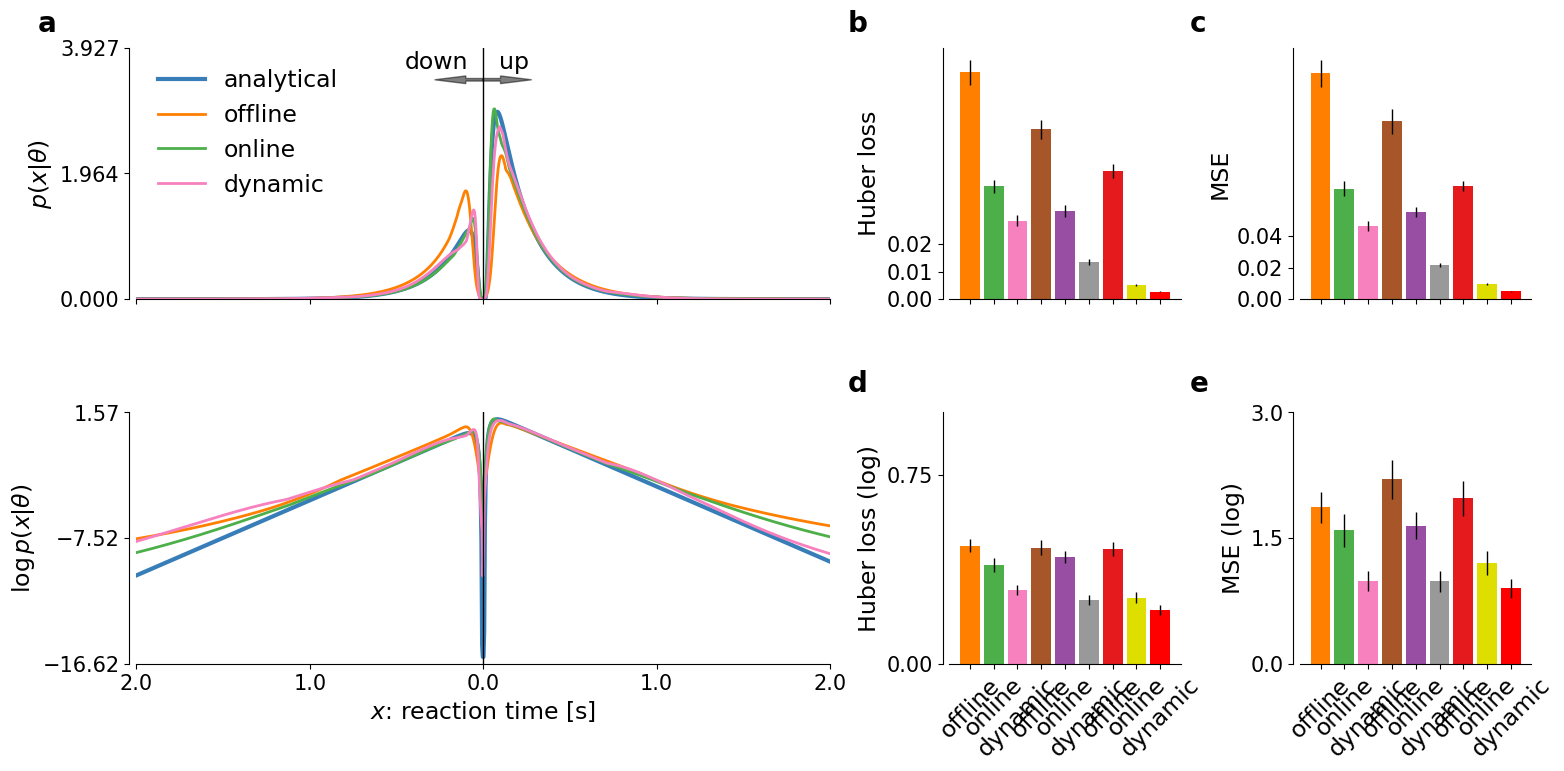

In [218]:
num_nets = 9

plt.style.use("plotting_settings.mplstyle")
fig, ax = plt.subplots(
    2,
    3,
    sharex="col",
    figsize=(18, 8),
    gridspec_kw=dict(wspace=0.31, hspace=0.45, width_ratios=[0.6, 0.2, 0.2]),
)

grid = False
showfliers = False
xticks = np.arange(-2, 2.1, 1)

#alphas = [1, 0.3, 0.6, 1, 1]
alphas = list(np.ones(num_nets+1))
#alphas = [1, 1, 1, 1, 1]
#plot_colors = [colors[0], colors[1], colors[1], colors[1], colors[2]]
plot_colors = colors#[colors[0], colors[1], colors[2], colors[3], colors[4]]
rotation = 45
y_axis_setoff = -0.01
mpl.rcParams["lines.linewidth"] = 1.0
lw = 2


plt.sca(ax[0, 0])
plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0], lw=lw + 1)
# plt.plot(
#     test_rts,
#     #lps_lan_5.exp(),
#     label=labels[1],
#     ls="-",
#     c=colors[1],
#     alpha=alphas[1],
#     lw=lw,
# )
# plt.plot(
#     test_rts,
#     #lps_lan_8.exp(),
#     label=labels[2],
#     ls="-",
#     c=colors[1],
#     alpha=alphas[2],
#     lw=lw,
# )
# plt.plot(
#     test_rts,
#     #lps_lan_11.exp(),
#     label=labels[3],
#     ls="-",
#     c=colors[1],
#     alpha=alphas[3],
#     lw=lw,
# )
plt.plot(test_rts, lps_mnle_1.exp(), label="MNLE1", ls="-", c=colors[1], lw=lw)
plt.plot(test_rts, lps_mnle_2.exp(), label="MNLE2", ls="-", c=colors[2], lw=lw)
plt.plot(test_rts, lps_mnle_3.exp(), label="MNLE3", ls="-", c=colors[3], lw=lw)
plt.ylabel(r"$p(x | \theta)$")
#plt.legend(labels, loc=1, handlelength=1.5, bbox_to_anchor=(1.03, 1.1))
plt.legend(labels, loc="upper left")
plt.xticks(xticks, [])
#ymax = max(max(lps_mnle_1.exp()), max(lps_mnle_2.exp()))
ymax = max(lps_true.exp()) + 1.0#0.1
#ymin = min(lps_true.exp()) - 0.5#0.1
#plt.yticks(np.linspace(0, 1.4, 3))
plt.yticks(np.linspace(0, ymax, 3))
#plt.ylim([-0.1, 1.4])
plt.ylim([0, ymax])
plt.xlim(-2, 2)
plt.axvline(0, color="k", lw=1)
plt.arrow(0, ymax-0.5, 0.1, 0.0, width=0.04, color="k", alpha=0.5)
plt.text(0.09, 1.05 * (ymax-0.5), s="up")
plt.arrow(0, ymax-0.5, -0.1, 0.0, width=0.04, color="k", alpha=0.5)
plt.text(-0.45, 1.05 * (ymax-0.5), s="down")
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))
# plt.yticks(np.linspace(0, 4, 5), np.linspace(0, 4, 5))
# plt.suptitle(fr"v={theta_o[0, 0]:.2f}, a={theta_o[0, 1]:.2f}, w={theta_o[0, 2]:.2f}, $\tau$={theta_o[0, 3]:.2f}");

plt.sca(ax[1, 0])
plt.plot(test_rts, lps_true, c=colors[0], lw=lw + 1)
# plt.plot(test_rts, lps_lanana)
# plt.plot(test_rts, lps_lan_5, ls="-", c=colors[1], alpha=alphas[1], lw=lw)
# plt.plot(test_rts, lps_lan_8, ls="-", c=colors[1], alpha=alphas[2], lw=lw)
# plt.plot(test_rts, lps_lan_11, ls="-", c=colors[1], alpha=alphas[3], lw=lw)
plt.plot(test_rts, lps_mnle_1, ls="-", c=colors[1], lw=lw)
plt.plot(test_rts, lps_mnle_2, ls="-", c=colors[2], lw=lw)
plt.plot(test_rts, lps_mnle_3, ls="-", c=colors[3], lw=lw)
# plt.legend(labels)
plt.xlabel("$x$: reaction time [s]")
plt.ylabel(r"$\log p(x | \theta)$")
plt.xticks(xticks, abs(xticks))
ymax = max(lps_true) + 0.5#0.1
ymin = min(lps_true) - 0.5
plt.yticks(np.linspace(ymin, ymax, 3))
plt.ylim([ymin, ymax])
plt.xlim(-2, 2)
plt.axvline(0, color="k", lw=1)
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

y_axis_setoff = -0.03
plt.sca(ax[0, 1])
box_widths = [0.5] * 4
pos = []
width = 0.1
pos_scale = 0.12
for ii in range(num_nets):
    pos.append(ii * pos_scale)
    plot_bar(
        pos[ii],
        width,
        df_huber.values[:, ii],
        label=labels[ii + 1],
        color=plot_colors[ii + 1],
        alpha=alphas[ii + 1],
    )
plt.xticks(pos, labels[1:], rotation=rotation)
plt.ylabel("Huber loss")
plt.yticks(np.linspace(0, 0.02, 3))
#plt.ylim(0, 0.02)
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

plt.sca(ax[0, 2])
for ii in range(num_nets):
    plot_bar(
        pos[ii],
        width,
        df_mse.values[:, ii],
        label=labels[ii + 1],
        color=plot_colors[ii + 1],
        alpha=alphas[ii + 1],
    )
plt.xticks(pos, labels[1:], rotation=rotation)
plt.ylabel(r"MSE")
plt.yticks(np.linspace(0, 0.04, 3))
#plt.ylim(0, 0.04)
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))


plt.sca(ax[1, 1])
for ii in range(num_nets):
    plot_bar(
        pos[ii],
        width,
        df_huber_log.values[:, ii],
        label=labels[ii + 1],
        color=plot_colors[ii + 1],
        alpha=alphas[ii + 1],
    )
plt.xticks(pos, labels[1:], rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"])
plt.ylabel("Huber loss (log)")
plt.yticks(np.linspace(0, 3, 5))
plt.ylim(0, 1)
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

plt.sca(ax[1, 2])
for ii in range(num_nets):
    plot_bar(
        pos[ii],
        width,
        df_mse_log.values[:, ii],
        label=labels[ii + 1],
        color=plot_colors[ii + 1],
        alpha=alphas[ii + 1],
    )
plt.xticks(pos, labels[1:], rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"])
plt.ylabel(r"MSE (log)")
plt.yticks(np.linspace(0, 3, 3))
#plt.yticks(np.linspace(0, 1.5, 3))
#plt.ylim(0, 3)
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

weight = "bold"
fontsize = 20
y1 = 0.9
x1 = 0.07
dx = 0.45
dx2 = 0.64
dy = 0.45
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx2, y1, "c", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1 - dy, "d", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx2, y1 - dy, "e", fontsize=fontsize, fontweight=weight)
plt.tight_layout()
# fig.savefig(
#     "figures/Figure2-MNLE-LAN-likelihood-comparison.png", dpi=300, bbox_inches="tight"
# )
# fig.savefig("figures/Figure 2.pdf", dpi=400, bbox_inches="tight");

In [209]:
labels = [
    "analytical",
    # r"LAN$^5$",
    # r"LAN$^8$",
    # r"LAN$^{11}$",
    # r"offlineMNLE$5e^4$",
    # r"onlineMNLE$5e^4$",
    # r"onlineMNLE$5e^4+$AMSGrad",
    #r"offlineMNLE$^{5e^4}$",
    #r"onlineMNLE$^{5e^4}$",
    #r"onlineMNLE$^{5e^4}_{AMSGrad}$",
    # r"offline",
    # r"online",
    # r"dynamic",
    # r"offline",
    # r"online",
    # r"dynamic",
    # r"offline",
    # r"online",
    # r"dynamic",
    str(10**4),
    str(10**5),
    str(10**6),
]

In [210]:
# num_nets = 3

# plt.style.use("plotting_settings.mplstyle")
# fig, ax = plt.subplots(
#     2,
#     3,
#     sharex="col",
#     figsize=(18, 8),
#     gridspec_kw=dict(wspace=0.31, hspace=0.45, width_ratios=[0.6, 0.2, 0.2]),
# )

# grid = False
# showfliers = False
# xticks = np.arange(-2, 2.1, 1)

# alphas = [1, 0.3, 0.6, 1, 1]
# #alphas = list(np.ones(15))
# #alphas = np.linspace(0.1, 1, 3)
# #alphas = [1, 1, 1, 1, 1]
# #plot_colors = [colors[0], colors[1], colors[1], colors[1], colors[2]]
# plot_colors = colors#[colors[0], colors[1], colors[2], colors[3], colors[4]]
# rotation = 45
# y_axis_setoff = -0.01
# mpl.rcParams["lines.linewidth"] = 1.0
# lw = 2


# plt.sca(ax[0, 0])
# plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0], lw=lw + 1)
# plt.plot(test_rts, lps_mnle_1.exp(), label="MNLE1", ls="-", c=colors[1], lw=lw)
# plt.plot(test_rts, lps_mnle_2.exp(), label="MNLE2", ls="-", c=colors[2], lw=lw)
# plt.plot(test_rts, lps_mnle_3.exp(), label="MNLE3", ls="-", c=colors[3], lw=lw)
# plt.ylabel(r"$p(x | \theta)$")
# #plt.legend(labels, loc=1, handlelength=1.5, bbox_to_anchor=(1.03, 1.1))
# plt.legend(labels, loc="upper left")
# plt.xticks(xticks, [])
# #ymax = max(max(lps_mnle_1.exp()), max(lps_mnle_2.exp()))
# ymax = max(lps_true.exp()) + 1.0#0.1
# #ymin = min(lps_true.exp()) - 0.5#0.1
# #plt.yticks(np.linspace(0, 1.4, 3))
# plt.yticks(np.linspace(0, ymax, 3))
# #plt.ylim([-0.1, 1.4])
# plt.ylim([0, ymax])
# plt.xlim(-2, 2)
# plt.axvline(0, color="k", lw=1)
# plt.arrow(0, ymax-0.5, 0.1, 0.0, width=0.04, color="k", alpha=0.5)
# plt.text(0.09, 1.05 * (ymax-0.5), s="up")
# plt.arrow(0, ymax-0.5, -0.1, 0.0, width=0.04, color="k", alpha=0.5)
# plt.text(-0.45, 1.05 * (ymax-0.5), s="down")
# plt.gca().spines["left"].set_position(("axes", y_axis_setoff))
# # plt.yticks(np.linspace(0, 4, 5), np.linspace(0, 4, 5))
# # plt.suptitle(fr"v={theta_o[0, 0]:.2f}, a={theta_o[0, 1]:.2f}, w={theta_o[0, 2]:.2f}, $\tau$={theta_o[0, 3]:.2f}");

# plt.sca(ax[1, 0])
# plt.plot(test_rts, lps_true, c=colors[0], lw=lw + 1)
# # plt.plot(test_rts, lps_lanana)
# # plt.plot(test_rts, lps_lan_5, ls="-", c=colors[1], alpha=alphas[1], lw=lw)
# # plt.plot(test_rts, lps_lan_8, ls="-", c=colors[1], alpha=alphas[2], lw=lw)
# # plt.plot(test_rts, lps_lan_11, ls="-", c=colors[1], alpha=alphas[3], lw=lw)
# plt.plot(test_rts, lps_mnle_1, ls="-", c=colors[1], lw=lw)
# plt.plot(test_rts, lps_mnle_2, ls="-", c=colors[2], lw=lw)
# plt.plot(test_rts, lps_mnle_3, ls="-", c=colors[3], lw=lw)
# # plt.legend(labels)
# plt.xlabel("$x$: reaction time [s]")
# plt.ylabel(r"$\log p(x | \theta)$")
# plt.xticks(xticks, abs(xticks))
# ymax = max(lps_true) + 0.5#0.1
# ymin = min(lps_true) - 0.5
# plt.yticks(np.linspace(ymin, ymax, 3))
# plt.ylim([ymin, ymax])
# plt.xlim(-2, 2)
# plt.axvline(0, color="k", lw=1)
# plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

# y_axis_setoff = -0.03
# plt.sca(ax[0, 1])
# box_widths = [0.5] * 4
# pos = []
# width = 0.1
# pos_scale = 0.12
# for m in range(3):
#     for ii in range(num_nets):
#         jj = ii + m*num_nets
#         pos.append(ii * pos_scale)
#         plot_bar(
#             pos[ii],
#             width,
#             df_huber.values[:, jj],
#             label=labels[ii + 1],
#             color=plot_colors[m + 1],
#             alpha=alphas[m + 1],
#         )
# plt.xticks(pos, labels[1:], rotation=rotation)
# plt.ylabel("Huber loss")
# plt.yticks(np.linspace(0, 0.02, 3))
# #plt.ylim(0, 0.02)
# plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

# plt.sca(ax[0, 2])
# for m in range(3):
#     for ii in range(num_nets):
#         jj = ii + m*num_nets
#         pos.append(ii * pos_scale)
#         plot_bar(
#             pos[ii],
#             width,
#             df_mse.values[:, jj],
#             label=labels[ii + 1],
#             color=plot_colors[m + 1],
#             alpha=alphas[m + 1],
#         )
# plt.xticks(pos, labels[1:], rotation=rotation)
# plt.ylabel(r"MSE")
# plt.yticks(np.linspace(0, 0.04, 3))
# #plt.ylim(0, 0.04)
# plt.gca().spines["left"].set_position(("axes", y_axis_setoff))


# plt.sca(ax[1, 1])
# for m in range(3):
#     for ii in range(num_nets):
#         jj = ii + m*num_nets
#         pos.append(ii * pos_scale)
#         plot_bar(
#             pos[ii],
#             width,
#             df_huber_log.values[:, jj],
#             label=labels[ii + 1],
#             color=plot_colors[m + 1],
#             alpha=alphas[m + 1],
#         )
# plt.xticks(pos, labels[1:], rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"])
# plt.ylabel("Huber loss (log)")
# plt.yticks(np.linspace(0, 0.6, 3))
# #plt.ylim(0, 0.6)
# plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

# plt.sca(ax[1, 2])
# for m in range(3):
#     for ii in range(num_nets):
#         jj = ii + m*num_nets
#         pos.append(ii * pos_scale)
#         plot_bar(
#             pos[ii],
#             width,
#             df_mse_log.values[:, jj],
#             label=labels[ii + 1],
#             color=plot_colors[m + 1],
#             alpha=alphas[m + 1],
#         )
# plt.xticks(pos, labels[1:], rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"])
# plt.ylabel(r"MSE (log)")
# plt.yticks(np.linspace(0, 3, 3))
# #plt.yticks(np.linspace(0, 1.5, 3))
# #plt.ylim(0, 3)
# plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

# weight = "bold"
# fontsize = 20
# y1 = 0.9
# x1 = 0.07
# dx = 0.45
# dx2 = 0.64
# dy = 0.45
# fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
# fig.text(x1 + dx, y1, "b", fontsize=fontsize, fontweight=weight)
# fig.text(x1 + dx2, y1, "c", fontsize=fontsize, fontweight=weight)
# fig.text(x1 + dx, y1 - dy, "d", fontsize=fontsize, fontweight=weight)
# fig.text(x1 + dx2, y1 - dy, "e", fontsize=fontsize, fontweight=weight)
# plt.tight_layout()
# # fig.savefig(
# #     "figures/Figure2-MNLE-LAN-likelihood-comparison.png", dpi=300, bbox_inches="tight"
# # )
# # fig.savefig("figures/Figure 2.pdf", dpi=400, bbox_inches="tight");

In [211]:
sim_budgets = np.array([10**4,10**5,10**6])

findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic f

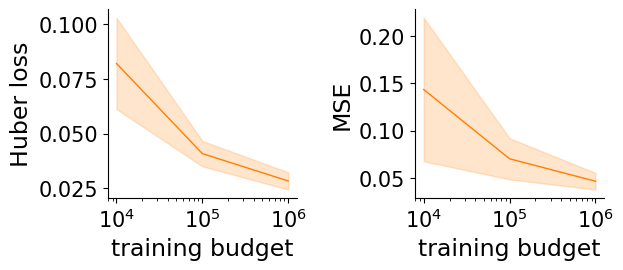

In [242]:
sys_errors_fig, sys_errors_ax = plt.subplots(1,2)
y_log_scale = True
alpha=0.2
mnle_color = colors[1]
#mnle_color_2 = "bisque"

num_nets_per_scheme = 5
huber_losses = []
MSEs = []

num_observations = 100
num_thetas_per_observation = 100
sidx = 0

errors_list = []

for num_net in range(num_nets_per_scheme):

    # Originally .mean(0) would take the average error over x NN inits for MNLE.
    errors_mnle = torch.tensor(
        np.array(
            [
                score_mnle(i_path, num_observations, num_thetas_per_observation)
                for i_path in mnle_model_paths[sidx:sidx+1]
            ]
        )
    ).mean(0)

    errors_list.append(errors_mnle)

    sidx += 1

    

for num_net in range(num_nets_per_scheme):
    error_type = 1

    errs1 = errors_mnle_1[:,error_type]
    errs2 = errors_mnle_2[:,error_type]
    errs3 = errors_mnle_3[:,error_type]

y = np.array([errs1.mean(),errs2.mean(),errs3.mean()])
yerr = np.array([errs1.var(),errs2.var(),errs3.var()])

col = 0

sys_errors_ax[col].plot(sim_budgets, y, c=mnle_color)
sys_errors_ax[col].fill_between(sim_budgets, y-yerr, y+yerr, color=mnle_color, alpha=alpha)
sys_errors_ax[col].set_xlabel("training budget")
sys_errors_ax[col].set_ylabel("Huber loss")
sys_errors_ax[col].set_box_aspect(1)
sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

sys_errors_ax[col].set_xscale('log')
   
error_type = 3

errs1 = errors_mnle_1[:,error_type]
errs2 = errors_mnle_2[:,error_type]
errs3 = errors_mnle_3[:,error_type]

y = np.array([errs1.mean(),errs2.mean(),errs3.mean()])
yerr = np.array([errs1.var(),errs2.var(),errs3.var()])

col = 1

sys_errors_ax[col].plot(sim_budgets, y, c=mnle_color)
sys_errors_ax[col].fill_between(sim_budgets, y-yerr, y+yerr, color=mnle_color, alpha=alpha)
sys_errors_ax[col].set_xlabel("training budget")
sys_errors_ax[col].set_ylabel("MSE")
sys_errors_ax[col].set_box_aspect(1)
sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

sys_errors_ax[col].set_xscale('log')

plt.tight_layout()

In [ ]:
sys_errors_fig, sys_errors_ax = plt.subplots(1,2)
y_log_scale = True
alpha=0.2
mnle_color = colors[1]
#mnle_color_2 = "bisque"

error_type = 1

errs1 = errors_mnle_1[:,error_type]
errs2 = errors_mnle_2[:,error_type]
errs3 = errors_mnle_3[:,error_type]

y = np.array([errs1.mean(),errs2.mean(),errs3.mean()])
yerr = np.array([errs1.var(),errs2.var(),errs3.var()])

col = 0

sys_errors_ax[col].plot(sim_budgets, y, c=mnle_color)
sys_errors_ax[col].fill_between(sim_budgets, y-yerr, y+yerr, color=mnle_color, alpha=alpha)
sys_errors_ax[col].set_xlabel("training budget")
sys_errors_ax[col].set_ylabel("Huber loss")
sys_errors_ax[col].set_box_aspect(1)
sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

sys_errors_ax[col].set_xscale('log')
   
error_type = 3

errs1 = errors_mnle_1[:,error_type]
errs2 = errors_mnle_2[:,error_type]
errs3 = errors_mnle_3[:,error_type]

y = np.array([errs1.mean(),errs2.mean(),errs3.mean()])
yerr = np.array([errs1.var(),errs2.var(),errs3.var()])

col = 1

sys_errors_ax[col].plot(sim_budgets, y, c=mnle_color)
sys_errors_ax[col].fill_between(sim_budgets, y-yerr, y+yerr, color=mnle_color, alpha=alpha)
sys_errors_ax[col].set_xlabel("training budget")
sys_errors_ax[col].set_ylabel("MSE")
sys_errors_ax[col].set_box_aspect(1)
sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

sys_errors_ax[col].set_xscale('log')

# col = 2
# sys_errors_ax[col].scatter(sim_budgets[0],sd_score_mnle_1/sd_score_ana,c=mnle_color,s=10)
# sys_errors_ax[col].scatter(sim_budgets[1],sd_score_mnle_2/sd_score_ana,c=mnle_color,s=10)
# sys_errors_ax[col].scatter(sim_budgets[2],sd_score_mnle_3/sd_score_ana,c=mnle_color,s=10)

# sys_errors_ax[col].set_xlabel("training budget")
# sys_errors_ax[col].set_ylabel("derivative score")
# sys_errors_ax[col].set_box_aspect(1)
# sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

# sys_errors_ax[col].set_xscale('log')

plt.tight_layout()

In [243]:
mnle_color = colors[2]
#mnle_color_2 = "bisque"

error_type = 1

errs1 = errors_mnle_4[:,error_type]
errs2 = errors_mnle_5[:,error_type]
errs3 = errors_mnle_6[:,error_type]

y = np.array([errs1.mean(),errs2.mean(),errs3.mean()])
yerr = np.array([errs1.var(),errs2.var(),errs3.var()])

col = 0

sys_errors_ax[col].plot(sim_budgets, y, c=mnle_color)
sys_errors_ax[col].fill_between(sim_budgets, y-yerr, y+yerr, color=mnle_color, alpha=alpha)
sys_errors_ax[col].set_xlabel("training budget")
sys_errors_ax[col].set_ylabel("Huber loss")
sys_errors_ax[col].set_box_aspect(1)
sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

sys_errors_ax[col].set_xscale('log')
   
error_type = 3

errs1 = errors_mnle_4[:,error_type]
errs2 = errors_mnle_5[:,error_type]
errs3 = errors_mnle_6[:,error_type]

y = np.array([errs1.mean(),errs2.mean(),errs3.mean()])
yerr = np.array([errs1.var(),errs2.var(),errs3.var()])

col = 1

sys_errors_ax[col].plot(sim_budgets, y, c=mnle_color)
sys_errors_ax[col].fill_between(sim_budgets, y-yerr, y+yerr, color=mnle_color, alpha=alpha)
sys_errors_ax[col].set_xlabel("training budget")
sys_errors_ax[col].set_ylabel("MSE")
sys_errors_ax[col].set_box_aspect(1)
sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

sys_errors_ax[col].set_xscale('log')

# col = 2
# sys_errors_ax[col].scatter(sim_budgets[0],sd_score_mnle_1/sd_score_ana,c=mnle_color,s=10)
# sys_errors_ax[col].scatter(sim_budgets[1],sd_score_mnle_2/sd_score_ana,c=mnle_color,s=10)
# sys_errors_ax[col].scatter(sim_budgets[2],sd_score_mnle_3/sd_score_ana,c=mnle_color,s=10)

# sys_errors_ax[col].set_xlabel("training budget")
# sys_errors_ax[col].set_ylabel("derivative score")
# sys_errors_ax[col].set_box_aspect(1)
# sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

# sys_errors_ax[col].set_xscale('log')

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [244]:
mnle_color = colors[3]
#mnle_color_2 = "bisque"

error_type = 1

errs1 = errors_mnle_7[:,error_type]
errs2 = errors_mnle_8[:,error_type]
errs3 = errors_mnle_9[:,error_type]

y = np.array([errs1.mean(),errs2.mean(),errs3.mean()])
yerr = np.array([errs1.var(),errs2.var(),errs3.var()])

col = 0

sys_errors_ax[col].plot(sim_budgets, y, c=mnle_color)
sys_errors_ax[col].fill_between(sim_budgets, y-yerr, y+yerr, color=mnle_color, alpha=alpha)
sys_errors_ax[col].set_xlabel("training budget")
sys_errors_ax[col].set_ylabel("Huber loss")
sys_errors_ax[col].set_box_aspect(1)
sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

sys_errors_ax[col].set_xscale('log')
if y_log_scale:
    sys_errors_ax[col].set_yscale('log')
   
error_type = 3

errs1 = errors_mnle_7[:,error_type]
errs2 = errors_mnle_8[:,error_type]
errs3 = errors_mnle_9[:,error_type]

y = np.array([errs1.mean(),errs2.mean(),errs3.mean()])
yerr = np.array([errs1.var(),errs2.var(),errs3.var()])

col = 1

sys_errors_ax[col].plot(sim_budgets, y, c=mnle_color)
sys_errors_ax[col].fill_between(sim_budgets, y-yerr, y+yerr, color=mnle_color, alpha=alpha)
#sys_errors_ax[col].scatter(sim_budgets[2], 0.001, c=mnle_color)
sys_errors_ax[col].set_xlabel("training budget")
sys_errors_ax[col].set_ylabel("MSE")
sys_errors_ax[col].set_box_aspect(1)
sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

sys_errors_ax[col].set_xscale('log')
if y_log_scale:
    sys_errors_ax[col].set_yscale('log')
    

# col = 2
# sys_errors_ax[col].scatter(sim_budgets[0],sd_score_mnle_1/sd_score_ana,c=mnle_color,s=10)
# sys_errors_ax[col].scatter(sim_budgets[1],sd_score_mnle_2/sd_score_ana,c=mnle_color,s=10)
# sys_errors_ax[col].scatter(sim_budgets[2],sd_score_mnle_3/sd_score_ana,c=mnle_color,s=10)

# sys_errors_ax[col].set_xlabel("training budget")
# sys_errors_ax[col].set_ylabel("derivative score")
# sys_errors_ax[col].set_box_aspect(1)
# sys_errors_ax[col].spines[['right', 'top']].set_visible(False)

# sys_errors_ax[col].set_xscale('log')

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Generic f

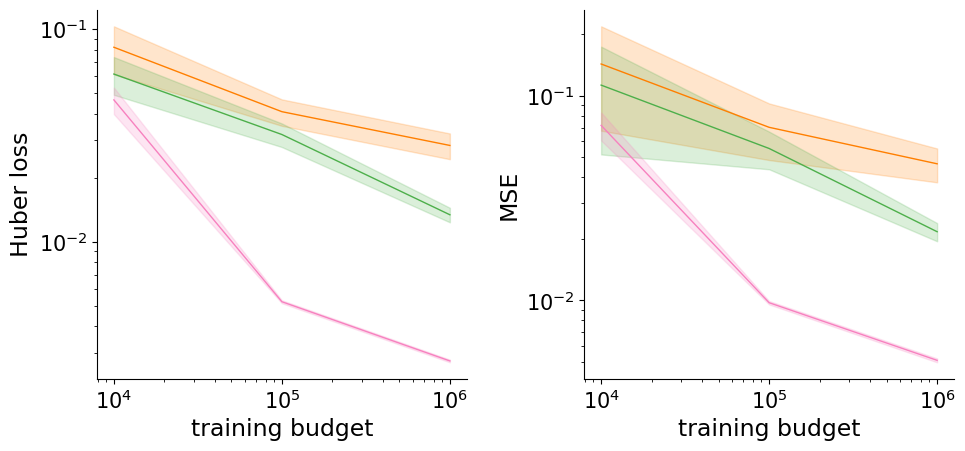

In [245]:
sys_errors_fig.set_size_inches(10, 5)
sys_errors_fig.tight_layout()
sys_errors_fig

### Medians and pairwise comparisons

In [ ]:
# rename columns for better access.
df_huber.columns = ["LAN5", "LAN8", "LAN", "MNLE"]
df_mse.columns = ["LAN5", "LAN8", "LAN", "MNLE"]
df_huber_log.columns = ["LAN5", "LAN8", "LAN", "MNLE"]
df_mse_log.columns = ["LAN5", "LAN8", "LAN", "MNLE"]

In [ ]:
print("linear scale")
df_huber.mean(), df_mse.mean()

linear scale


(LAN5    0.016608
 LAN8    0.007546
 LAN     0.005851
 MNLE    0.003765
 dtype: float64,
 LAN5    0.035513
 LAN8    0.013400
 LAN     0.010533
 MNLE    0.007237
 dtype: float64)

In [ ]:
print("log scale")
df_huber_log.mean(), df_mse_log.mean()

log scale


(LAN5    0.430696
 LAN8    0.374137
 LAN     0.188713
 MNLE    0.233783
 dtype: float64,
 LAN5    2.267289
 LAN8    2.173839
 LAN     1.032648
 MNLE    0.924024
 dtype: float64)

In [ ]:
# helper fun for comparisons
def num_a_greater_b_and_binom_test(a, b):
    num_a_greater_b = (a > b).sum()
    return num_a_greater_b, binom_test(num_a_greater_b, num_observations, 0.5)

In [ ]:
print("Huber loss")
for ll in [df_huber.LAN5, df_huber.LAN8, df_huber.LAN]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=df_huber.MNLE)
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")

print("MLE")
for ll in [df_mse.LAN5, df_mse.LAN8, df_mse.LAN]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=df_mse.MNLE)
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")

print("Huber loss (log)")
for ll in [df_huber_log.LAN5, df_huber_log.LAN8, df_huber_log.LAN]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(
        a=ll, b=df_huber_log.MNLE
    )
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")

print("MSE (log)")
for ll in [df_mse_log.LAN5, df_mse_log.LAN8, df_mse_log.LAN]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=df_mse_log.MNLE)
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")

Huber loss
LAN > MNLE: 99, p=1.5934990285464438e-28
LAN > MNLE: 81, p=2.7027625220487884e-10
LAN > MNLE: 66, p=0.0017899303914868528
MLE
LAN > MNLE: 98, p=7.969072864542661e-27
LAN > MNLE: 81, p=2.7027625220487884e-10
LAN > MNLE: 66, p=0.0017899303914868528
Huber loss (log)
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 38, p=0.02097873567785172
MSE (log)
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 75, p=5.636282034205402e-07
